In [1]:
from typing import Tuple
import pandas as pd
from tqdm.notebook import tqdm
import sys
sys.path.append('..')
from evaluation.generated_dataset import GeneratedDataset, load_all_from_config
from evaluation.novelty import NoveltyFilter, filter_by_unique_structure

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [2]:
raw_datasets = {
    "WyFormer": ("WyckoffTransformer", "CrySPR", "CHGNet_fix"),
    "WyForDiffCSP++": ("WyckoffTransformer", "DiffCSP++"),
    "DiffCSP": ("DiffCSP",)
}

In [3]:
all_datasets = load_all_from_config(
    datasets=list(raw_datasets.values()) + \
        [("split", "train"), ("split", "val"), ("split", "test")],
    dataset_name="carbon_24")

In [4]:
novelty_reference = pd.concat([
    all_datasets[('split', 'train')].data,
    all_datasets[('split', 'val')].data], axis=0, verify_integrity=True)
novelty_filter = NoveltyFilter(novelty_reference)

In [5]:
import evaluation.statistical_evaluator
test_evaluator = evaluation.statistical_evaluator.StatisticalEvaluator(
    all_datasets[('split', 'test')].data, cdvae_eval_model_name="carbon")

In [6]:
import evaluation.novelty
train_w_template_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1))
train_strict_AFLOW_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1))
train_relaxed_AFLOW_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_relaxed_AFLOW_fingerprint, axis=1))

In [7]:
carbon_24 = pd.concat([
    all_datasets[('split', 'train')].data,
    all_datasets[('split', 'val')].data,
    all_datasets[('split', 'test')].data], axis=0, verify_integrity=True)

In [8]:
table = pd.DataFrame(
    index=raw_datasets.keys(), columns=[
        "Novelty (%)", "Structural", "Compositional", 
        "Recall", "Precision",
        r"$\rho$", "$E$", "# Elements",
        "Novel Template (%)", 
        "Novel AFLOW on P1",
        "Novel AFLOW on !P1",
        "Novel AFLOW (%)",
        "Novel AFLOW relaxed (%)",
        "P1 (%)",
        "Space Group"])
table.index.name = "Method"
E_hull_threshold = 0.08
for name, transformations in tqdm(raw_datasets.items()):
    dataset = all_datasets[transformations]
    unique = filter_by_unique_structure(dataset.data)
    print(f"Unique: {len(unique)} / {len(dataset.data)} = {len(unique) / len(dataset.data)}")
    novel_template = ~unique.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1).isin(train_w_template_set)
    table.loc[name, "Novel Template (%)"] = 100 * novel_template.mean()
    novel_aflow_strict = ~unique.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1).isin(train_strict_AFLOW_set)
    table.loc[name, "Novel AFLOW (%)"] = 100 * novel_aflow_strict.mean()
    novel_aflow_relaxed = ~unique.apply(evaluation.novelty.record_to_relaxed_AFLOW_fingerprint, axis=1).isin(train_relaxed_AFLOW_set)
    table.loc[name, "Novel AFLOW relaxed (%)"] = 100 * novel_aflow_relaxed.mean()
    unique_is_P1 = unique.group == 1
    table.loc[name, "Novel AFLOW on P1"] = 100 * novel_aflow_strict[unique_is_P1].mean()
    table.loc[name, "Novel AFLOW on !P1"] = 100 * novel_aflow_strict[~unique_is_P1].mean()
    if transformations == ("split", "train"):
        novel = unique
    else:
        novel = novelty_filter.get_novel(unique)
    table.loc[name, "Novelty (%)"] = 100 * len(novel) / len(unique)
    if "structural_validity" in novel.columns:
        table.loc[name, "Structural"] = 100 * novel.structural_validity.mean()
        table.loc[name, "Compositional"] = 100 * novel.smact_validity.mean()
    if "cdvae_crystal" in novel.columns:
        cov_metrics = test_evaluator.get_coverage(novel.cdvae_crystal)    
        table.loc[name, "Recall"] = 100 * cov_metrics["cov_recall"]
        table.loc[name, "Precision"] = 100 * cov_metrics["cov_precision"]
        novel = novel[novel.structural_validity]
        table.loc[name, r"$\rho$"] = test_evaluator.get_density_emd(novel)
        table.loc[name, "$E$"] = test_evaluator.get_cdvae_e_emd(novel)
        table.loc[name, "# Elements"] = test_evaluator.get_num_elements_emd(novel)
    table.loc[name, "P1 (%)"] = 100 * (novel.group == 1).mean()
    table.loc[name, "Space Group"] = test_evaluator.get_sg_chi2(novel)
table

  0%|          | 0/3 [00:00<?, ?it/s]

Unique: 501 / 1000 = 0.501


KeyboardInterrupt: 

In [18]:
cdvae_table = pd.DataFrame(index=pd.Index(raw_datasets.keys(), tupleize_cols=False),
    columns=[
        "Structural", "Compositional",
        "Recall", "Precision",
        r"$\rho$", "$E$", "# Elements"])

for name, transformations in tqdm(raw_datasets.items()):
    dataset = all_datasets[transformations]
    if "structure" in dataset.data.columns:
        cdvae_table.loc[name, "Compositional"] = 100*dataset.data.smact_validity.mean()
        cdvae_table.loc[name, "Structural"] = 100*dataset.data.structural_validity.mean()
        valid = dataset.data[dataset.data.naive_validity]
        cov_metrics = test_evaluator.get_coverage(valid.cdvae_crystal.to_list())
        cdvae_table.loc[name, "Recall"] = 100*cov_metrics["cov_recall"]
        cdvae_table.loc[name, "Precision"] = 100*cov_metrics["cov_precision"]
        cdvae_table.loc[name, r"$\rho$"] = test_evaluator.get_density_emd(valid)
        cdvae_table.loc[name, "$E$"] = test_evaluator.get_cdvae_e_emd(valid)
        cdvae_table.loc[name, "# Elements"] = test_evaluator.get_num_elements_emd(valid)
cdvae_table.to_csv("tables/cdvae_metrics_no_relax_table.csv")
#prettify(cdvae_table).to_latex("tables/cdvae_metrics_no_relax_table.tex", siunitx=True, convert_css=True)
#prettify(cdvae_table)

  0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
cdvae_table

,Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements
WyFormer,100.0,100.0,77.2,98.423645,1.110789,0.102047,0.0
WyForDiffCSP++,99.7,81.4,0.0,0.0,3.365404,0.419817,2.087546
DiffCSP,100.0,100.0,98.41,99.802956,0.076489,0.044992,0.0


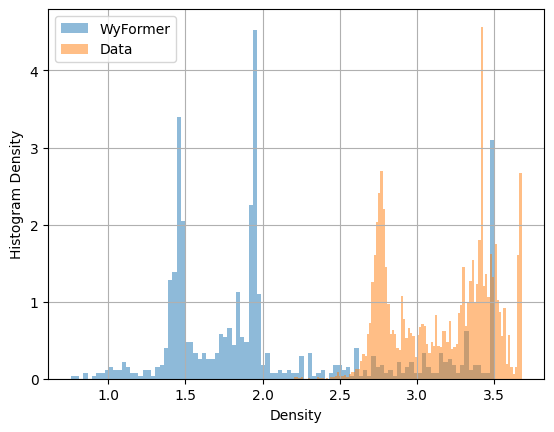

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
all_datasets[('WyckoffTransformer', 'CrySPR', 'CHGNet_fix')].data.density.hist(
    ax=ax, bins=100, alpha=0.5, label="WyFormer", density=True)
carbon_24.density.hist(ax=ax, bins=100, alpha=0.5, label="Data", density=True)
ax.set_xlabel("Density")
ax.set_ylabel("Histogram Density")
ax.legend();